In [1]:
import requests
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# This notebook focuses on Visualization. 
# For the ETL process, see src/etl_pipeline.py

import sys
sys.path.append('../src')

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# 1. Load environment variables (Point to the .env file in the folder above)
load_dotenv('../.env')

# 2. Re-create the database connection
# We need this 'engine' variable to run your SQL queries
db_user = os.getenv("DB_USER")
db_pass = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")

connection_string = f"mysql+mysqlconnector://{db_user}:{db_pass}@{db_host}/{db_name}"
engine = create_engine(connection_string)

print("Libraries loaded and Database connected!")

Libraries loaded and Database connected!


# Analysis and Visualizations

## Development SQL Query: Average Debt-to-GDP and Electricity Access

In [6]:
# Run development SQL Query
sql_development_trap = """
SELECT 
    country,
    country_group,
    ROUND(AVG(CASE 
        WHEN indicator_code = 'GC.DOD.TOTL.GD.ZS' 
        THEN value END), 2) AS avg_debt_gdp,
    ROUND(AVG(CASE 
        WHEN indicator_code = 'EG.ELC.ACCS.ZS' 
        THEN value END), 2) AS avg_electricity_access
FROM economic_indicators
GROUP BY country, country_group
HAVING avg_debt_gdp IS NOT NULL AND avg_electricity_access IS NOT NULL;
"""

df_trap = pd.read_sql(sql_development_trap, engine)

## Visualize Development Trap: Debt vs. Electricity Access Scatter Plot

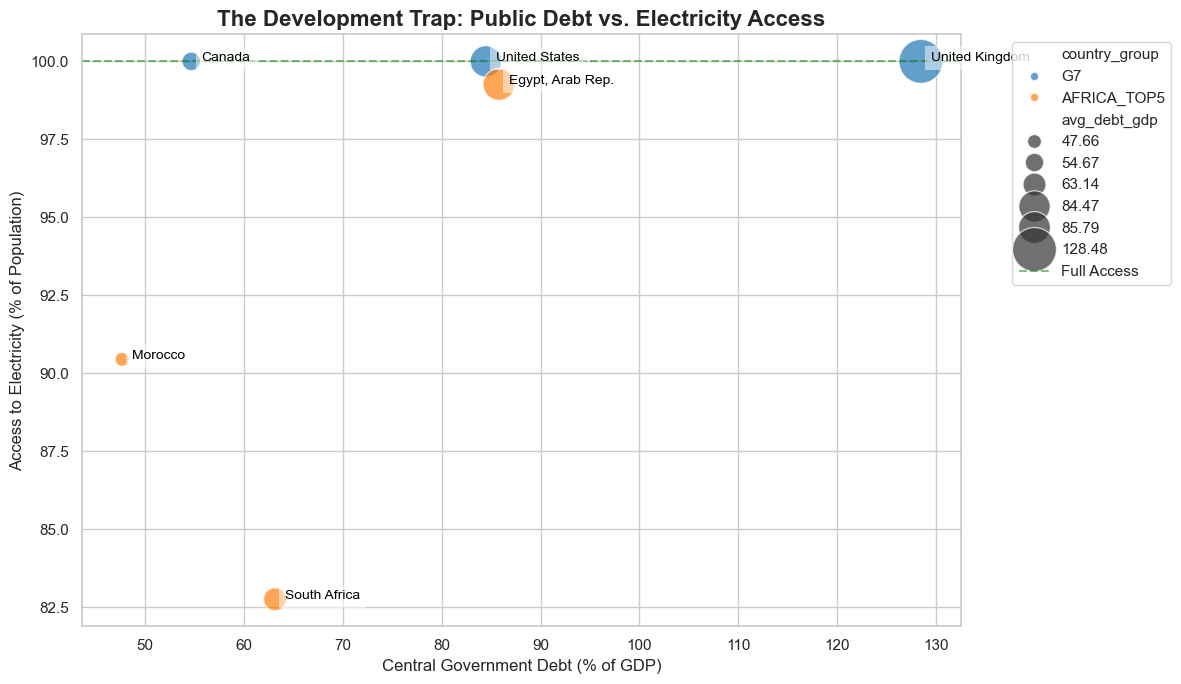

In [7]:
# Visualize: Scatter Plot
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create the plot
scatter = sns.scatterplot(
    data=df_trap, 
    x='avg_debt_gdp', 
    y='avg_electricity_access', 
    hue='country_group',      # Color by Group
    size='avg_debt_gdp',      # Bubble size based on debt
    sizes=(100, 1000), 
    alpha=0.7,
    palette={'G7': '#1f77b4', 'AFRICA_TOP5': '#ff7f0e'}
)

# Add labels to the points
for i in range(df_trap.shape[0]):
    plt.text(
        x=df_trap.avg_debt_gdp[i]+1, 
        y=df_trap.avg_electricity_access[i], 
        s=df_trap.country[i], 
        fontdict=dict(color='black', size=10),
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

# Formatting
plt.title('The Development Trap: Public Debt vs. Electricity Access', fontsize=16, fontweight='bold')
plt.xlabel('Central Government Debt (% of GDP)', fontsize=12)
plt.ylabel('Access to Electricity (% of Population)', fontsize=12)
plt.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Full Access')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Visualize Financial Depth vs. Infrastructure Development

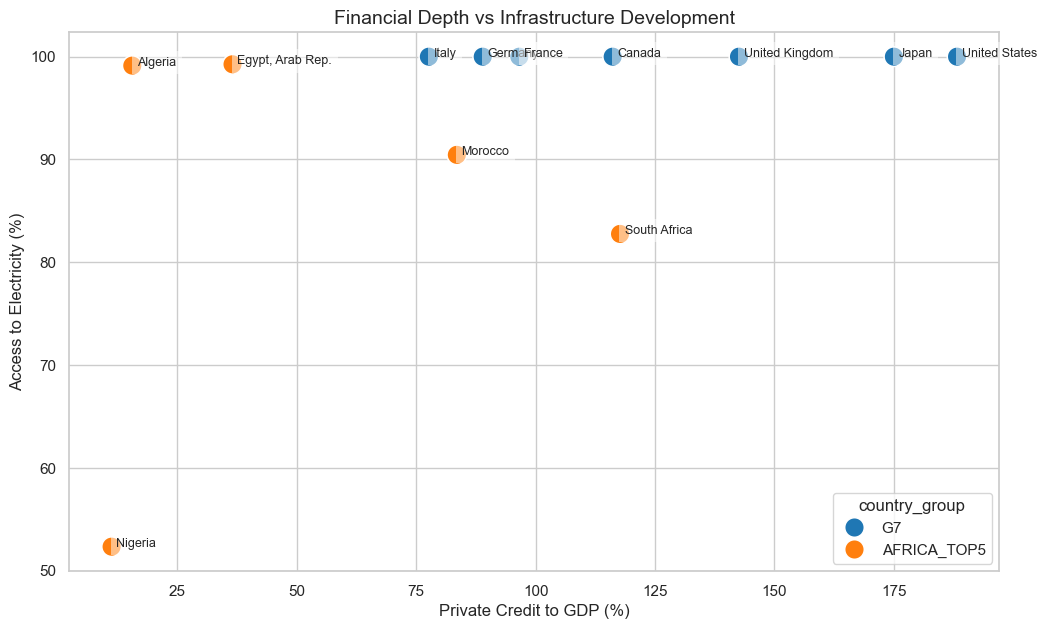

In [8]:
# Visualization: Financial Depth vs Infrastructure Development
# Private Credit is used as a measure of financial depth, offering a more stable and comparable signal across countries.

sql_financial_depth = """
SELECT 
    country,
    country_group,
    ROUND(AVG(CASE 
        WHEN indicator_code = 'FS.AST.PRVT.GD.ZS' 
        THEN value END), 2) AS avg_private_credit,
    ROUND(AVG(CASE 
        WHEN indicator_code = 'EG.ELC.ACCS.ZS' 
        THEN value END), 2) AS avg_electricity_access
FROM economic_indicators
GROUP BY country, country_group
HAVING avg_private_credit IS NOT NULL
   AND avg_electricity_access IS NOT NULL;
"""

df_financial_depth = pd.read_sql(sql_financial_depth, engine)

# Scatter plot: Financial Depth vs Infrastructure
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_financial_depth,
    x="avg_private_credit",
    y="avg_electricity_access",
    hue="country_group",
    s=200,
    palette={"G7": "#1f77b4", "AFRICA_TOP5": "#ff7f0e"}
)

# Country labels
for i in range(df_financial_depth.shape[0]):
    plt.text(
        x=df_financial_depth.avg_private_credit[i] + 1,
        y=df_financial_depth.avg_electricity_access[i],
        s=df_financial_depth.country[i],
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
    )

plt.title("Financial Depth vs Infrastructure Development", fontsize=14)
plt.xlabel("Private Credit to GDP (%)", fontsize=12)
plt.ylabel("Access to Electricity (%)", fontsize=12)
plt.show()